Input datasets:
- training_data_no_filter.csv
- training_data_MS_filter.csv
- training_data_MS_iso_filter.csv

This notebook includes:
- Results of hyperparameter grid search
- Training and testing of random forest classifiers (all and seq)
- Feature importance analysis

# Import libraries

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scikitplot as skplt
import seaborn as sns
import os

from imblearn.under_sampling import RandomUnderSampler
from matplotlib import patches
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Define paths

In [2]:
Data_path = os.path.dirname(os.getcwd()) + '/Data'
Model_path = os.path.dirname(os.getcwd()) + '/Models'

# Import dataset

In [3]:
hp = pd.read_csv(Data_path + '/curated/features_human_proteome.csv', sep=',')

### Feature datasets

In [4]:
df_no_filter = pd.read_csv(Data_path + '/training/training_data_no_filter.csv', sep=',')
df_MS_filter = pd.read_csv(Data_path + '/training/training_data_MS_filter.csv', sep=',')
df_MS_iso_filter = pd.read_csv(Data_path + '/training/training_data_MS_iso_filter.csv', sep=',')

# Create Random Forest models

### Preprocess data

In [5]:
features_cont = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                 'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                 'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

In [6]:
def preprocess(df):
    
    # define explanatory and response variables
    X = df.drop(["id", "EV"], axis=1)
    y = df["EV"]
    
    # undersample majority class
    undersample = RandomUnderSampler(random_state=0)
    X_balanced, y_balanced = undersample.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [7]:
def split_and_scale(X_balanced, y_balanced, features_cont=features_cont, scaler=RobustScaler()):

    # split 80% training and 20% test 
    train_X, test_X, train_y, test_y = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0, 
        stratify=y_balanced)
    
    # robust scaling
    train_X_scaled = train_X.copy()
    test_X_scaled = test_X.copy()
    train_X_scaled[features_cont] = scaler.fit_transform(train_X[features_cont])
    test_X_scaled[features_cont] = scaler.transform(test_X[features_cont])
    
    print("Size of training set:", len(train_X_scaled))
    print("Size of test set:", len(test_X_scaled))
    
    return train_X_scaled, train_y, test_X_scaled, test_y 

In [8]:
print("Dataset with no filtering")
X_balanced_1, y_balanced_1 = preprocess(df_no_filter)
train_X_1, train_y_1, test_X_1, test_y_1 = split_and_scale(X_balanced_1, y_balanced_1)
print("---------------------")
print("Dataset with MS filtering")
X_balanced_2, y_balanced_2 = preprocess(df_MS_filter)
train_X_2, train_y_2, test_X_2, test_y_2 = split_and_scale(X_balanced_2, y_balanced_2)
print("---------------------")
print("Dataset with MS and isolation method filtering")
X_balanced_3, y_balanced_3 = preprocess(df_MS_iso_filter)
train_X_3, train_y_3, test_X_3, test_y_3 = split_and_scale(X_balanced_3, y_balanced_3)

Dataset with no filtering
Size of training set: 13452
Size of test set: 3364
---------------------
Dataset with MS filtering
Size of training set: 8817
Size of test set: 2205
---------------------
Dataset with MS and isolation method filtering
Size of training set: 9544
Size of test set: 2386


## Train the random forest (all features)

In [9]:
rf_1 = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_1.fit(train_X_1, train_y_1)

rf_2 = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_2.fit(train_X_2, train_y_2)

rf_3 = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_3.fit(train_X_3, train_y_3)

RandomForestClassifier(max_features=10, n_estimators=1000, random_state=0)

## Save/load zipped models (all features)

In [10]:
file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter.pkl', 'wb')
file.write(pickle.dumps(rf_1))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter.pkl', 'wb')
file.write(pickle.dumps(rf_2))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter.pkl', 'wb')
file.write(pickle.dumps(rf_3))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter.pkl', 'rb')
rf_1 = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter.pkl', 'rb')
rf_2 = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter.pkl', 'rb')
rf_3 = pickle.loads(file.read())
file.close()

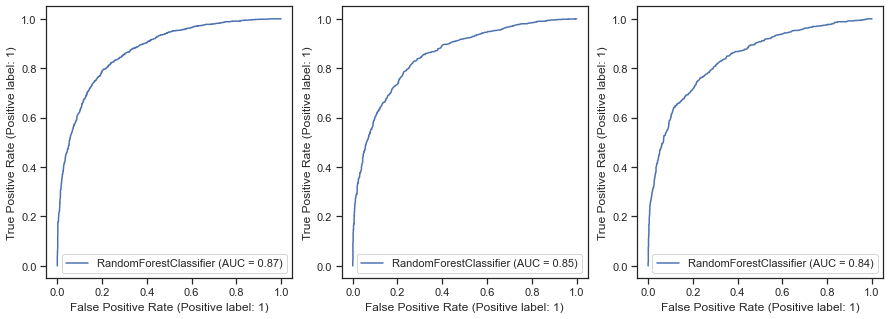

In [11]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, figsize=(15,5))

RocCurveDisplay.from_estimator(rf_1, test_X_1, test_y_1, ax=ax[0])
RocCurveDisplay.from_estimator(rf_2, test_X_2, test_y_2, ax=ax[1])
RocCurveDisplay.from_estimator(rf_3, test_X_3, test_y_3, ax=ax[2])

plt.show()

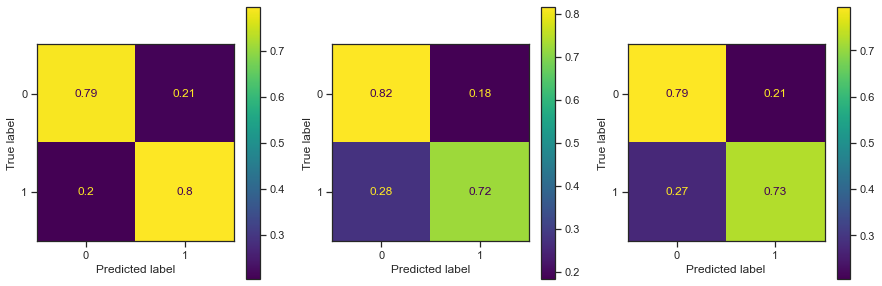

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ConfusionMatrixDisplay.from_estimator(rf_1, test_X_1, test_y_1, normalize="true", ax=ax[0])
ConfusionMatrixDisplay.from_estimator(rf_2, test_X_2, test_y_2, normalize="true", ax=ax[1])
ConfusionMatrixDisplay.from_estimator(rf_3, test_X_3, test_y_3, normalize="true", ax=ax[2])

plt.show()

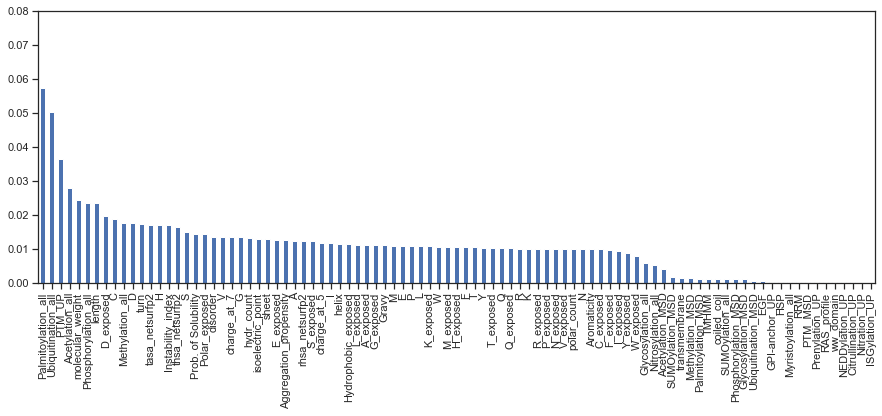

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index=train_X_1.columns, data=rf_1.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')
ax.set_ylim((0,0.08))

plt.show()

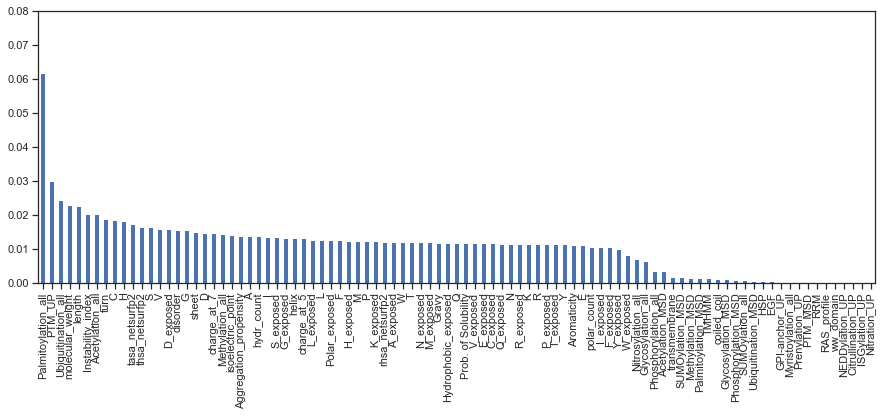

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index=train_X_2.columns, data=rf_2.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')
ax.set_ylim((0,0.08))

plt.show()

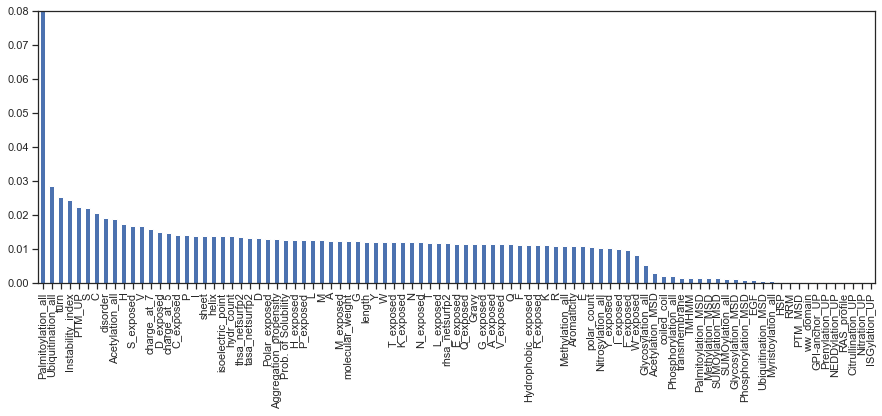

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index=train_X_3.columns, data=rf_3.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')
ax.set_ylim((0,0.08))

plt.show()

## Train the random forest (sequence-based features)

In [16]:
# use only sequence-based features
seq_features = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM',
                'TMHMM', 'Polar_exposed', 'Hydrophobic_exposed']

In [17]:
train_X_1_seq = train_X_1[seq_features]
test_X_1_seq = test_X_1[seq_features]

train_X_2_seq = train_X_2[seq_features]
test_X_2_seq = test_X_2[seq_features]

train_X_3_seq = train_X_3[seq_features]
test_X_3_seq = test_X_3[seq_features]

In [18]:
rf_1_seq = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_1_seq.fit(train_X_1_seq, train_y_1)

rf_2_seq = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_2_seq.fit(train_X_2_seq, train_y_2)

rf_3_seq = RandomForestClassifier(random_state=0, n_estimators=1000, max_features=10)
rf_3_seq.fit(train_X_3_seq, train_y_3)

RandomForestClassifier(max_features=10, n_estimators=1000, random_state=0)

## Save/load zipped models (sequence-based features)

In [19]:
file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter_seq.pkl', 'wb')
file.write(pickle.dumps(rf_1_seq))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter_seq.pkl', 'wb')
file.write(pickle.dumps(rf_2_seq))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter_seq.pkl', 'wb')
file.write(pickle.dumps(rf_3_seq))
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_no_filter_seq.pkl', 'rb')
rf_1_seq = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_filter_seq.pkl', 'rb')
rf_2_seq = pickle.loads(file.read())
file.close()

file = gzip.GzipFile(Model_path + '/EV_RF_model_MS_iso_filter_seq.pkl', 'rb')
rf_3_seq = pickle.loads(file.read())
file.close()

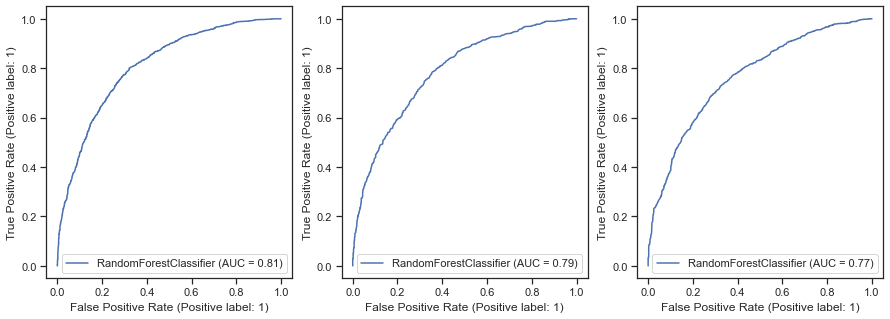

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

RocCurveDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, ax=ax[0])
RocCurveDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, ax=ax[1])
RocCurveDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, ax=ax[2])

plt.show()

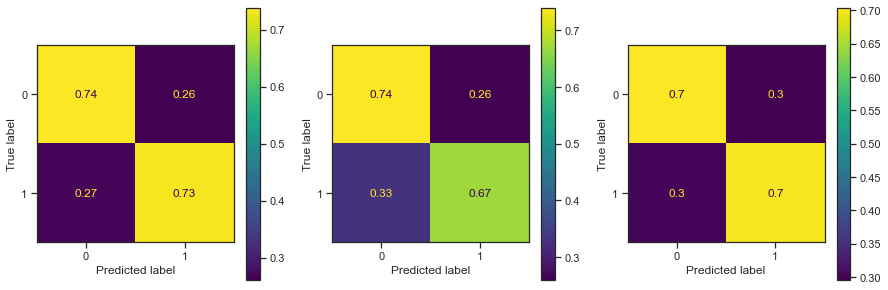

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ConfusionMatrixDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, normalize="true", ax=ax[0])
ConfusionMatrixDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, normalize="true", ax=ax[1])
ConfusionMatrixDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, normalize="true", ax=ax[2])

plt.show()

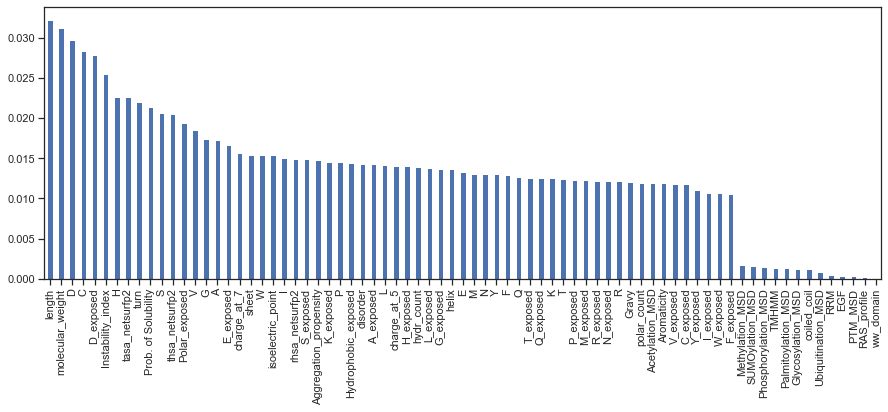

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index = train_X_1_seq.columns, data = rf_1_seq.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')

plt.show()

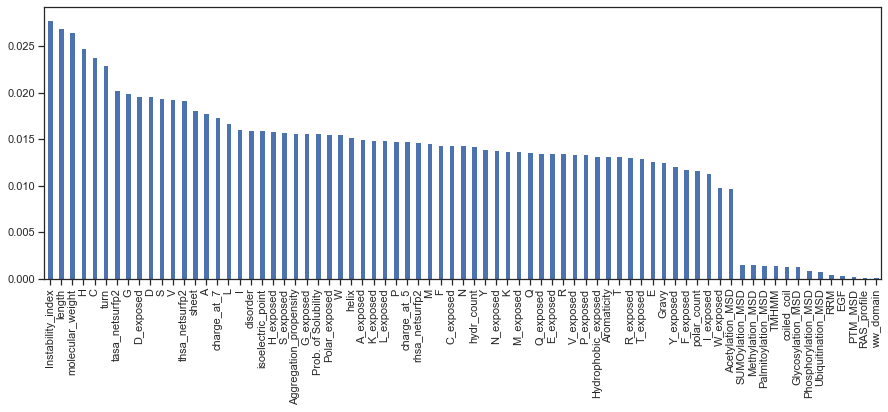

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index = train_X_2_seq.columns, data = rf_2_seq.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')

plt.show()

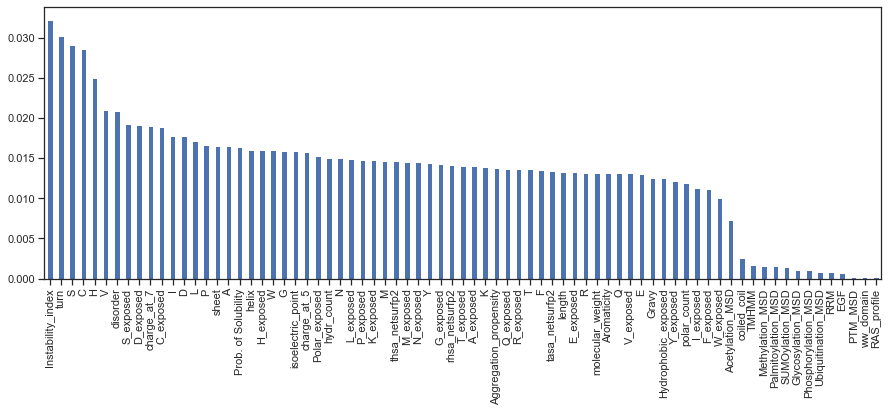

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

feature_importance = pd.Series(index = train_X_3_seq.columns, data = rf_3_seq.feature_importances_)
feature_importance.sort_values(ascending=False).plot(kind='bar')

plt.show()

# Compare models

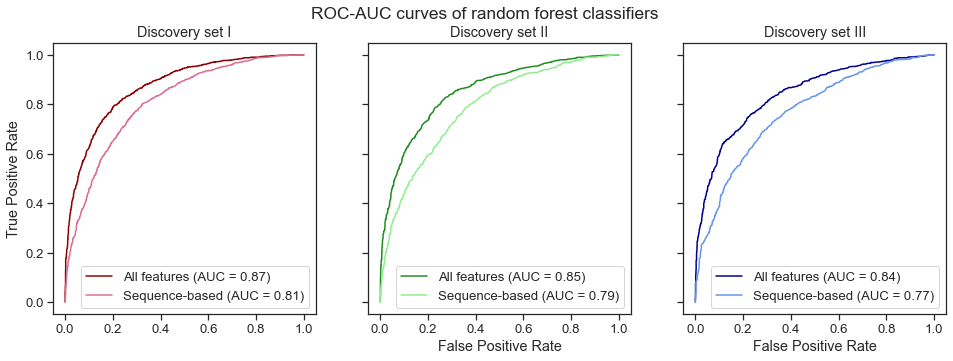

In [25]:
# figure settings
sns.set(style=("ticks"), font_scale=1.2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

RocCurveDisplay.from_estimator(rf_1, test_X_1, test_y_1, color='darkred', name="All features", ax=ax1)
RocCurveDisplay.from_estimator(rf_1_seq, test_X_1_seq, test_y_1, color='palevioletred', name="Sequence-based", 
                               ax=ax1)
ax1.set(xlabel=None, ylabel="True Positive Rate", title="Discovery set I")
RocCurveDisplay.from_estimator(rf_2, test_X_2, test_y_2, color='forestgreen', name="All features", ax=ax2)
RocCurveDisplay.from_estimator(rf_2_seq, test_X_2_seq, test_y_2, color='lightgreen', name="Sequence-based", ax=ax2)
ax2.set(xlabel="False Positive Rate", ylabel=None, title="Discovery set II")
RocCurveDisplay.from_estimator(rf_3, test_X_3, test_y_3, color='darkblue', name="All features", ax=ax3)
RocCurveDisplay.from_estimator(rf_3_seq, test_X_3_seq, test_y_3, color='cornflowerblue', name="Sequence-based", ax=ax3)
ax3.set(xlabel="False Positive Rate", ylabel=None, title="Discovery set III")
fig.suptitle("ROC-AUC curves of random forest classifiers")

plt.show()

In [26]:
# retrieve feature importances
fi_rf_3 = pd.DataFrame(data={"Feature":train_X_3.columns, "Discovery set III":rf_3.feature_importances_})
fi_rf_2 = pd.DataFrame(data={"Feature":train_X_2.columns, "Discovery set II":rf_2.feature_importances_})
fi_rf_1 = pd.DataFrame(data={"Feature":train_X_1.columns, "Discovery set I":rf_1.feature_importances_})

In [27]:
# create dataframe of feature importances
df_FI = fi_rf_3
df_FI = df_FI.merge(fi_rf_2, on="Feature")
df_FI = df_FI.merge(fi_rf_1, on="Feature")
df_FI_sorted = df_FI.sort_values("Discovery set III", ascending=False)

# created melted dataframe
df_FI_top_melted = df_FI_sorted[:20].melt(id_vars=['Feature'], 
    value_vars=["Discovery set III", "Discovery set II", "Discovery set I"], var_name="Filter", value_name="Importance")

In [28]:
# retrieve pairwise feature correlation
corr_MS_iso = df_MS_iso_filter.corr()
corr_MS = df_MS_filter.corr()
corr_all = df_no_filter.corr()

# create dataframe of feature correlations
df_corr = corr_MS_iso[['EV']]
df_corr = df_corr.merge(corr_MS[['EV']], left_index=True, right_index=True)
df_corr = df_corr.merge(corr_all[['EV']], left_index=True, right_index=True)
df_corr.columns = ["Discovery set III", "Discovery set II", "Discovery set I"]

In [29]:
# change order of correlation values to feature importance ranking
corr_top = df_corr.reindex(df_FI_sorted["Feature"])

# rename columns for figure, mark annotations
corr_top.rename(index={'Palmitoylation_all':'Palmitoylation¹', 
                  'PTM_UP':'PTM¹', 
                  'molecular_weight':'Molecular weight',
                  'Instability_index':'Instability index',
                  'length':'Sequence length', 
                  'turn':'Turn', 
                  'Acetylation_all':'Acetylation¹',
                  'tasa_netsurfp2':'TASA', 
                  'thsa_netsurfp2':'THSA',
                  'disorder':'Disorder', 
                  'D_exposed':'Exposed D', 
                  'Ubiquitination_all':'Ubiquitination¹', 
                  'sheet':'Sheet', 
                  'Sum_AA_exposed': 'Exposed residues', 
                  'S_exposed':'Exposed S', 
                  'Aggregation_propensity':'Aggregation propensity',
                  'L_exposed':'Exposed L', 
                  'rhsa_netsurfp2':'RHSA', 
                  'isoelectric_point':'Isoelectric point', 
                  'charge_at_7':'Charge at pH 7',
                  'on_surface': 'Hydrophobic residues on surface', 
                  'Methylation_all':'Methylation¹', 
                  'charge_at_5':'Charge at pH 5', 
                  'helix':'Helix',
                  'hydr_count':'Hydrophobic residues', 
                  'G_exposed':'Exposed G', 
                  'H_exposed':'Exposed H',
                  'Q_exposed':'Exposed Q', 
                  'N_exposed':'Exposed N', 
                  'C_exposed':'Exposed C', 
                  'A_exposed':'Exposed A', 
                  'K_exposed':'Exposed K', 
                  'V_exposed':'Exposed V', 
                  'E_exposed':'Exposed E', 
                  'M_exposed':'Exposed M', 
                  'T_exposed':'Exposed T', 
                  'Glycosylation_all':'Glycosylation¹', 
                  'R_exposed':'Exposed R', 
                  'P_exposed':'Exposed P', 
                  'Y_exposed':'Exposed Y',
                  'polar_count':'Polar residues', 
                  'F_exposed':'Exposed F', 
                  'I_exposed':'Exposed I', 
                  'Nitrosylation_all':'Nitrosylation¹',
                  'W_exposed':'Exposed W', 
                  'Acetylation_MSD':'Acetylation predicted', 
                  'Phosphorylation_all':'Phosphorylation¹', 
                  'transmembrane':'Transmembrane',
                  'SUMOylation_MSD':'SUMOylation predicted', 
                  'Methylation_MSD':'Methylation predicted', 
                  'Palmitoylation_MSD':'Palmitoylation predicted', 
                  'coiled_coil': 'Coiled coil domain', 
                  'Lipoprotein_UP':'Lipoprotein¹', 
                  'Glycosylation_MSD':'Glycosylation predicted',
                  'SUMOylation_all':'SUMOylation¹',
                  'Phosphorylation_MSD':'Phosphorylation predicted',
                  'Ubiquitination_MSD':'Ubiquitination predicted',
                  'PTM_MSD':'PTM predicted',
                  'Myristoylation_all':'Myristoylation¹', 
                  'Prenylation_UP':'Prenylation¹', 
                  'GPI-anchor_UP':'GPI-anchor¹', 
                  'ww_domain':'WW domain',
                  'NEDDylation_UP':'NEDDylation¹', 
                  'RAS_profile':'RAS profile', 
                  'Citrullination_UP':'Citrullination¹', 
                  'Nitration_UP':'Nitration¹',
                  'ISGylation_UP':'ISGylation¹',
                  'HSP':'HSP¹',
                  'Polar_exposed':'Exposed polar residues',
                  'Hydrophobic_exposed':'Exposed hydrophobic residues'}, inplace=True)

corr_top = corr_top.rename_axis('Feature').reset_index()[:20]

# created melted dataframe
df_corr_top_melted = corr_top.melt(id_vars=['Feature'], value_vars=["Discovery set III", "Discovery set II", "Discovery set I"], 
    var_name="Filter", value_name="Correlation")
df_corr_top_melted[:5]

,Feature,Filter,Correlation
0,Palmitoylation¹,Discovery set III,0.426463
1,Ubiquitination¹,Discovery set III,0.264611
2,Turn,Discovery set III,-0.199371
3,Instability index,Discovery set III,-0.216693
4,PTM¹,Discovery set III,0.228689


In [30]:
# use only Discover set III - referred to the Discovery set in the manuscript
df_corr_top_melted_DS3 = df_corr_top_melted[df_corr_top_melted["Filter"] == "Discovery set III"]
df_FI_top_melted_D3 = df_FI_top_melted[df_FI_top_melted["Filter"] == "Discovery set III"]

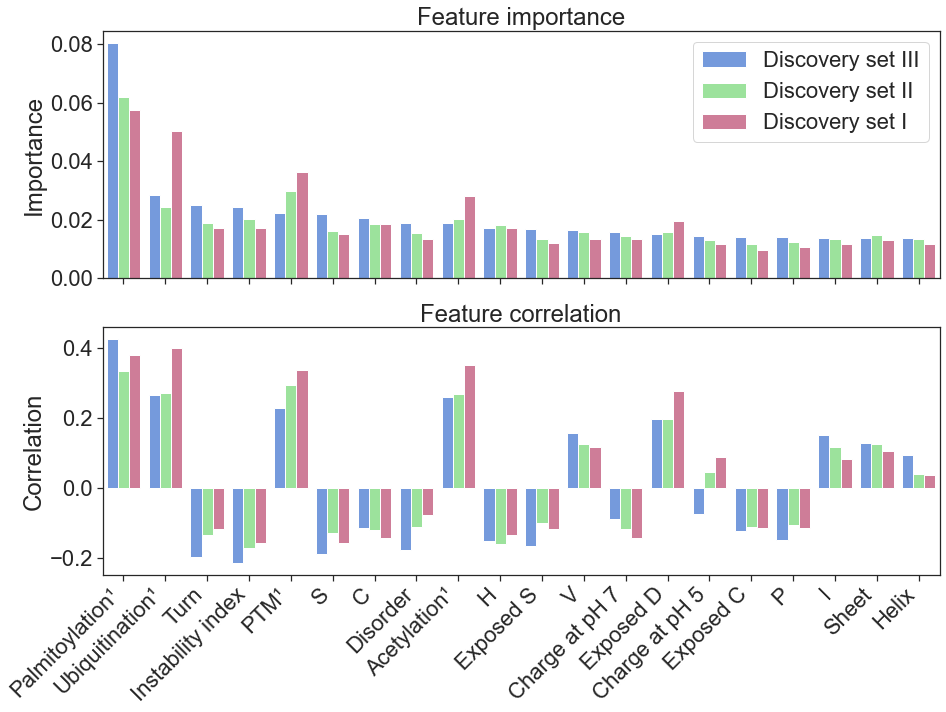

In [31]:
sns.set(style=("ticks"), font_scale=2)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
plt.subplots_adjust(hspace=0.2)

# set colors for filter types
palette = {"Discovery set III": "cornflowerblue", "Discovery set II": "lightgreen", "Discovery set I": "palevioletred"}

# plot feature importance (top 20)
bar = sns.barplot(x="Feature", y="Importance", data=df_FI_top_melted, hue="Filter", palette=palette, ax= axs[0])
bar.legend(title="")
bar.set(xlabel=None, ylabel="Importance", title="Feature importance", xticklabels=[])

# plot corresponding correlation
bar = sns.barplot(x="Feature", y="Correlation", data=df_corr_top_melted, hue="Filter", palette=palette, ax= axs[1])
bar.legend()
bar.set(xlabel=None, ylabel="Correlation", title="Feature correlation")
axs[1].set_xticklabels(df_corr_top_melted["Feature"][:20], rotation = 45, ha="right")
axs[1].get_legend().remove()

plt.show()

No handles with labels found to put in legend.


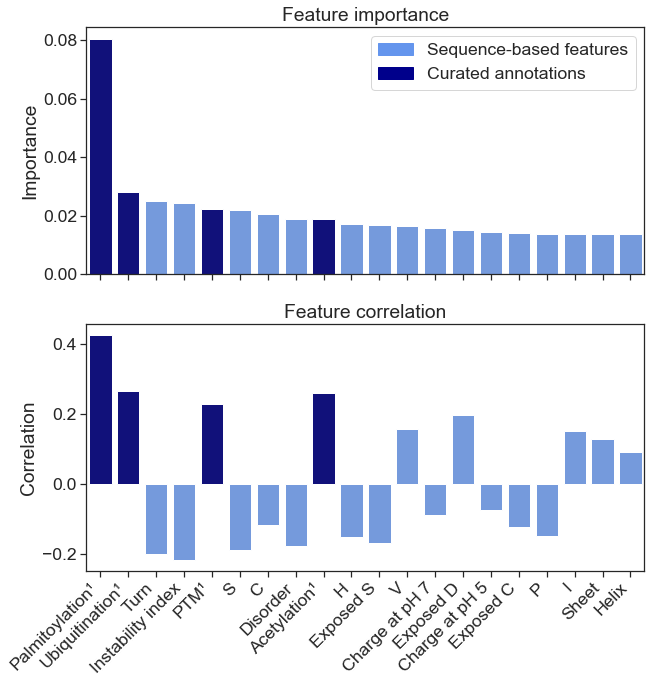

In [32]:
sns.set(style=("ticks"), font_scale=1.6)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.2)

pal=["darkblue", "darkblue", "cornflowerblue", "cornflowerblue", "darkblue", "cornflowerblue", "cornflowerblue",  
     "cornflowerblue", "darkblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue",
     "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue", "cornflowerblue",
     "cornflowerblue"]

# plot feature importance (top 20)
bar = sns.barplot(x="Feature", y="Importance", data=df_FI_top_melted_D3, palette=pal, ax=axs[0])
bar.set(xlabel=None, ylabel="Importance", title="Feature importance", xticklabels=[])
# bar.legend(title="")

# create legend
seq_feat = patches.Patch(color="cornflowerblue", label="Sequence-based features")
all_feat = patches.Patch(color="darkblue", label="Curated annotations")
bar.legend(handles=[seq_feat, all_feat]);

# plot corresponding correlation
bar = sns.barplot(x="Feature", y="Correlation", data=df_corr_top_melted_DS3, palette=pal, ax= axs[1])
bar.legend()
bar.set(xlabel=None, ylabel="Correlation", title="Feature correlation")
axs[1].set_xticklabels(df_corr_top_melted["Feature"][:20], rotation = 45, ha="right")
axs[1].get_legend().remove()

plt.show()

## Filter effect on molecular weight

In [34]:
MS_all = pd.read_csv(Data_path + "/mapping/MS_proteome_UP_MW.tab", sep="\t")

MS_all["Mass"] = MS_all["Mass"].str.replace(',','').astype(float)
MS_all["Mass_log"] = MS_all["Mass"].transform(np.log2)

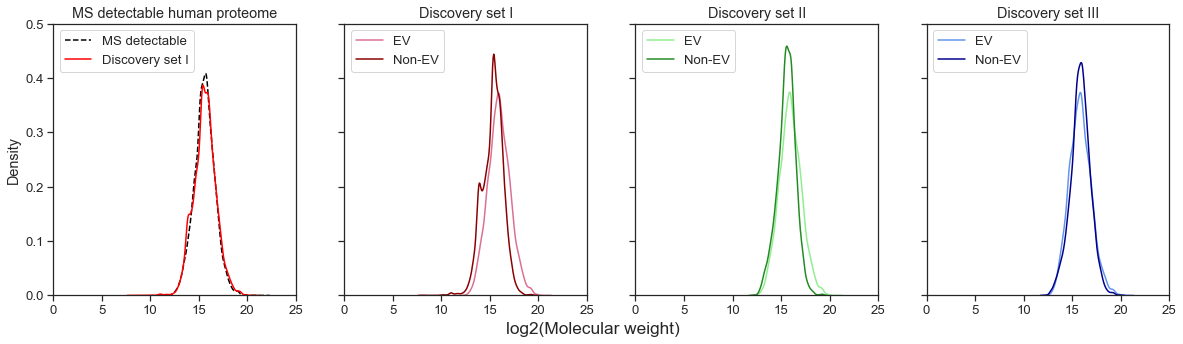

In [35]:
sns.set(style=("ticks"), palette="muted", font_scale=1.2)
fig, axs = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(20, 5))
plt.xlim((0, 25))   
plt.ylim((0, 0.5)) 

sns.kdeplot(x=MS_all['Mass_log'], ax=axs[0], color='black', label='MS detectable', linestyle="--")
sns.kdeplot(x=df_no_filter['molecular_weight'], ax=axs[0], color='red', label='Discovery set I')
axs[0].set(xlabel=None, ylabel="Density", title="MS detectable human proteome")
axs[0].legend(handles=axs[0].patches, labels=['MS detectable', 'Discovery set I'], loc="upper left")

sns.kdeplot(x=df_no_filter[df_no_filter["EV"] == 1]['molecular_weight'], ax=axs[1], color='palevioletred', 
            label='EV')
sns.kdeplot(x=df_no_filter[df_no_filter["EV"] == 0]['molecular_weight'], ax=axs[1], color="darkred", label='Non-EV')
axs[1].set(xlabel=None, ylabel=None, title="Discovery set I")
axs[1].legend(handles=axs[1].patches, labels=['EV', 'Non-EV'], loc="upper left")

# sns.kdeplot(x=MS_all['Mass_log'], ax=axs[1], color='black', label='MS detectable proteins', linestyle="--")
sns.kdeplot(x=df_MS_filter[df_MS_filter["EV"] == 1]['molecular_weight'], ax=axs[2], color='lightgreen', label='EV')
sns.kdeplot(x=df_MS_filter[df_MS_filter["EV"] == 0]['molecular_weight'], ax=axs[2], color="forestgreen", label='Non-EV')
axs[2].set(xlabel=None, ylabel=None, title="Discovery set II")
axs[2].legend(handles=axs[2].patches, labels=['EV', 'Non-EV'], loc="upper left")

sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]['molecular_weight'], ax=axs[3], color="cornflowerblue", 
            label='EV')
sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]['molecular_weight'], ax=axs[3], color="darkblue", 
            label='Non-EV')
axs[3].set(xlabel=None, ylabel=None, title="Discovery set III")
axs[3].legend(handles=axs[3].patches, labels=['EV', 'Non-EV'], loc="upper left")
fig.supxlabel("log2(Molecular weight)")

plt.show()

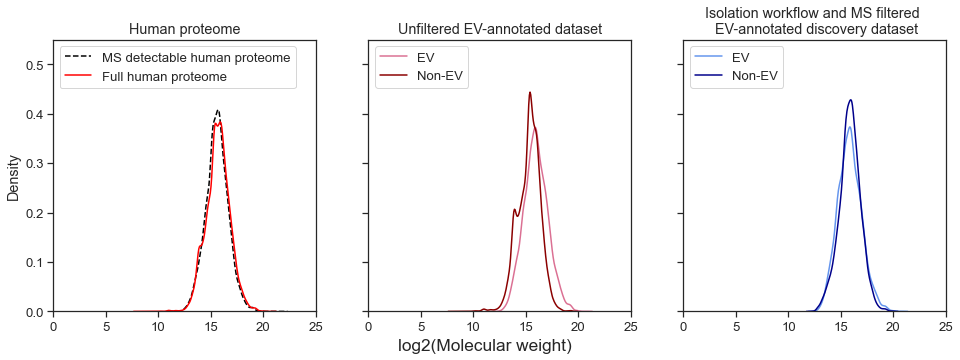

In [36]:
sns.set(style=("ticks"), palette="muted", font_scale=1.2)
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 5))
plt.xlim((0, 25))   
plt.ylim((0, 0.55)) 

sns.kdeplot(x=MS_all['Mass_log'], ax=axs[0], color='black', label="MS detectable human proteome", linestyle="--")
sns.kdeplot(x=hp['molecular_weight'], ax=axs[0], color='red', label="Full human proteome")
axs[0].set(xlabel=None, ylabel="Density", title="Human proteome")
axs[0].legend(handles=axs[0].patches, labels=["MS detectable human proteome", "Full human proteome"], loc="upper left")

sns.kdeplot(x=df_no_filter[df_no_filter["EV"] == 1]['molecular_weight'], ax=axs[1], color='palevioletred', 
            label='EV')
sns.kdeplot(x=df_no_filter[df_no_filter["EV"] == 0]['molecular_weight'], ax=axs[1], color="darkred", label='Non-EV')
axs[1].set(xlabel=None, ylabel=None, title="Unfiltered EV-annotated dataset")
axs[1].legend(handles=axs[1].patches, labels=['EV', 'Non-EV'], loc="upper left")

sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]['molecular_weight'], ax=axs[2], color="cornflowerblue", 
            label='EV')
sns.kdeplot(x=df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]['molecular_weight'], ax=axs[2], color="darkblue", 
            label='Non-EV')
axs[2].set(xlabel=None, ylabel=None, title="Isolation workflow and MS filtered \n EV-annotated discovery dataset")
axs[2].legend(handles=axs[2].patches, labels=['EV', 'Non-EV'], loc="upper left")
fig.supxlabel("log2(Molecular weight)")

plt.show()

In [37]:
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact

stat, p = mannwhitneyu(df_no_filter[df_no_filter["EV"] == 1]['molecular_weight'], df_no_filter[df_no_filter["EV"] == 0]['molecular_weight']) 
print("P-value no filter:", p)
stat, p = mannwhitneyu(df_MS_filter[df_MS_filter["EV"] == 1]['molecular_weight'], df_MS_filter[df_MS_filter["EV"] == 0]['molecular_weight']) 
print("P-value MS filter:", p)
stat, p = mannwhitneyu(df_MS_iso_filter[df_MS_iso_filter["EV"] == 1]['molecular_weight'], df_MS_iso_filter[df_MS_iso_filter["EV"] == 0]['molecular_weight']) 
print("P-value MS & isolation method filter:", p)

P-value no filter: 2.354026266343677e-267
P-value MS filter: 2.1469881053984618e-85
P-value MS & isolation method filter: 0.002423221914656409


In [38]:
# create data frame of all feature importance ranks
df_FI_rank = df_FI_sorted.copy()
df_FI_rank["Discovery set III"] = df_FI_sorted["Discovery set III"].rank()
df_FI_rank["Discovery set II"] = df_FI_sorted["Discovery set II"].rank()
df_FI_rank["Discovery set I"] = df_FI_sorted["Discovery set I"].rank()

df_FI_rank.set_index("Feature", inplace=True)

In [39]:
# rename columns for figure, mark annotations
df_FI_rank = df_FI_rank.rename(index={'Palmitoylation_all':'Palmitoylation¹', 
                  'PTM_UP':'PTM¹', 
                  'molecular_weight':'Molecular weight',
                  'Instability_index':'Instability index',
                  'length':'Sequence length', 
                  'turn':'Turn', 
                  'Acetylation_all':'Acetylation¹',
                  'tasa_netsurfp2':'TASA', 
                  'thsa_netsurfp2':'THSA',
                  'disorder':'Disorder', 
                  'D_exposed':'Exposed D', 
                  'Ubiquitination_all':'Ubiquitination¹', 
                  'sheet':'Sheet', 
                  'Sum_AA_exposed': 'Exposed residues', 
                  'S_exposed':'Exposed S', 
                  'Aggregation_propensity':'Aggregation propensity',
                  'L_exposed':'Exposed L', 
                  'rhsa_netsurfp2':'RHSA', 
                  'isoelectric_point':'Isoelectric point', 
                  'charge_at_7':'Charge at pH 7',
                  'on_surface': 'Hydrophobic residues on surface', 
                  'Methylation_all':'Methylation¹', 
                  'charge_at_5':'Charge at pH 5', 
                  'helix':'Helix',
                  'hydr_count':'Hydrophobic residues', 
                  'G_exposed':'Exposed G', 
                  'H_exposed':'Exposed H',
                  'Q_exposed':'Exposed Q', 
                  'N_exposed':'Exposed N', 
                  'C_exposed':'Exposed C', 
                  'A_exposed':'Exposed A', 
                  'K_exposed':'Exposed K', 
                  'V_exposed':'Exposed V', 
                  'E_exposed':'Exposed E', 
                  'M_exposed':'Exposed M', 
                  'T_exposed':'Exposed T', 
                  'Glycosylation_all':'Glycosylation¹', 
                  'R_exposed':'Exposed R', 
                  'P_exposed':'Exposed P', 
                  'Y_exposed':'Exposed Y',
                  'polar_count':'Polar residues', 
                  'F_exposed':'Exposed F', 
                  'I_exposed':'Exposed I', 
                  'Nitrosylation_all':'Nitrosylation¹',
                  'W_exposed':'Exposed W', 
                  'Acetylation_MSD':'Acetylation predicted', 
                  'Phosphorylation_all':'Phosphorylation¹', 
                  'transmembrane':'Transmembrane',
                  'SUMOylation_MSD':'SUMOylation predicted', 
                  'Methylation_MSD':'Methylation predicted', 
                  'Palmitoylation_MSD':'Palmitoylation predicted', 
                  'coiled_coil': 'Coiled coil domain', 
                  'Lipoprotein_UP':'Lipoprotein¹', 
                  'Glycosylation_MSD':'Glycosylation predicted',
                  'SUMOylation_all':'SUMOylation¹',
                  'Phosphorylation_MSD':'Phosphorylation predicted',
                  'Ubiquitination_MSD':'Ubiquitination predicted',
                  'PTM_MSD':'PTM predicted',
                  'Myristoylation_all':'Myristoylation¹', 
                  'Prenylation_UP':'Prenylation¹', 
                  'GPI-anchor_UP':'GPI-anchor¹', 
                  'ww_domain':'WW domain',
                  'NEDDylation_UP':'NEDDylation¹', 
                  'RAS_profile':'RAS profile', 
                  'Citrullination_UP':'Citrullination¹', 
                  'Nitration_UP':'Nitration¹',
                  'ISGylation_UP':'ISGylation¹',
                  'HSP':'HSP¹',
                  'Polar_exposed':'Exposed polar residues',
                  'Hydrophobic_exposed':'Exposed hydrophobic residues'})

In [40]:
df_FI_rank.columns = ["Isolation workflow and MS filtered \n EV-annotated discovery dataset", 
           "MS filtered EV-annotated dataset", "Unfiltered EV-annotated dataset"]

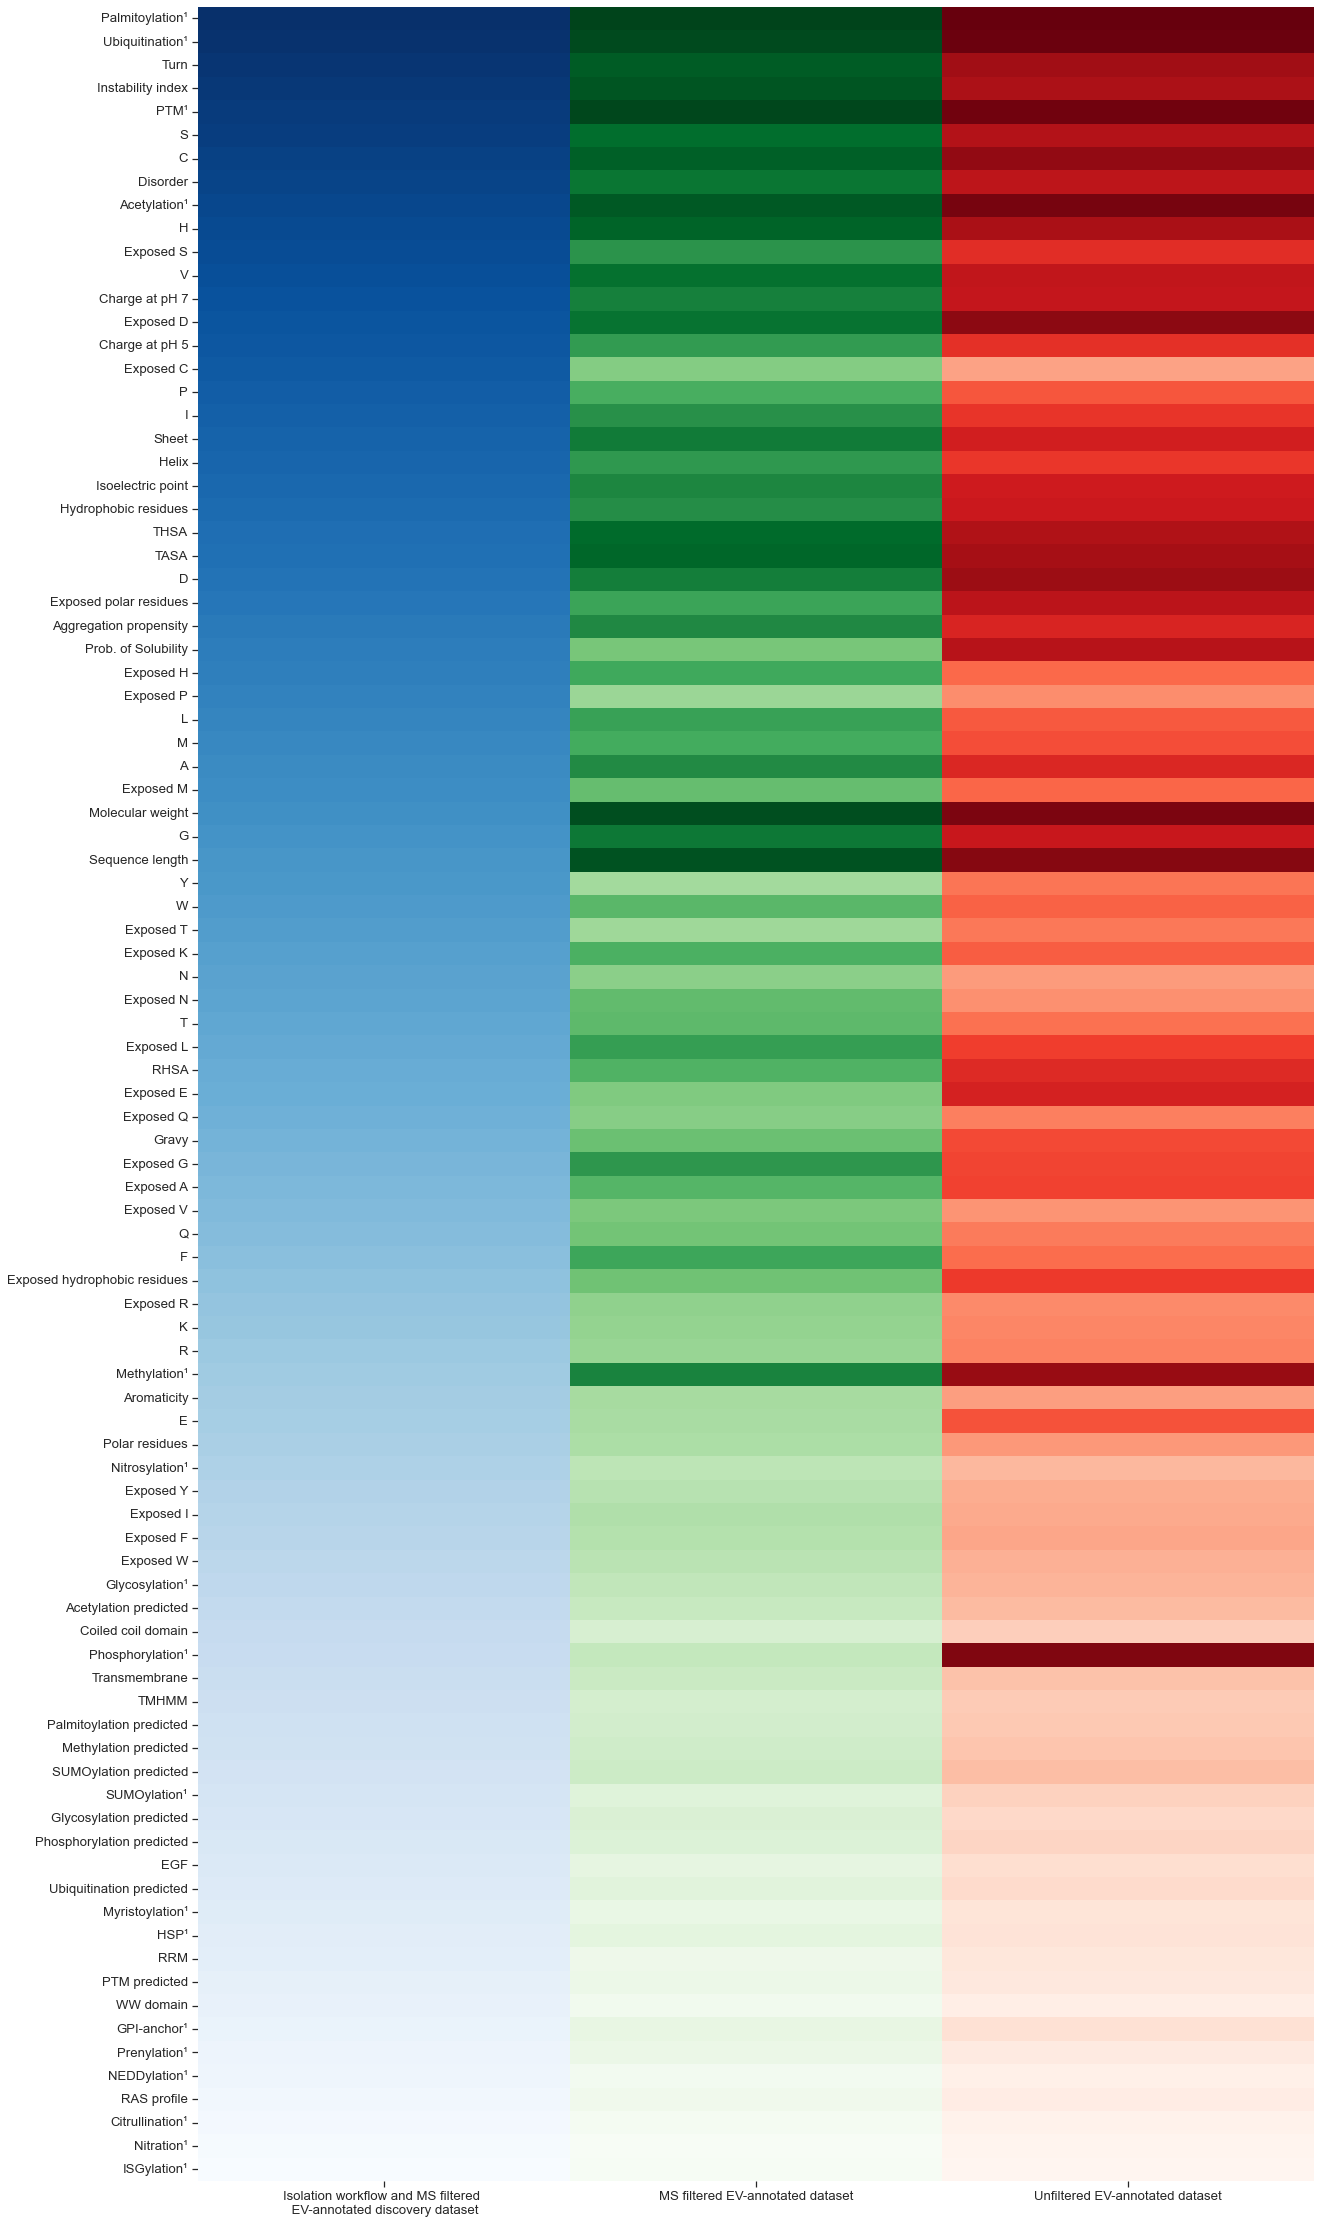

In [41]:
fig, axs = plt.subplots(1, df_FI_rank.columns.size, gridspec_kw={'wspace': 0}, figsize=(20, 40))

cm = ['Blues', 'Greens', 'Reds']
classes = [["Isolation workflow and MS filtered \n EV-annotated discovery dataset"], 
           ["MS filtered EV-annotated dataset"], 
           ["Unfiltered EV-annotated dataset"]]

for i, (s, a, c) in enumerate(zip(df_FI_rank.columns, axs, cm)):
    sns.heatmap(np.array([df_FI_rank[s].values]).T, yticklabels=df_FI_rank.index, xticklabels=classes[i], fmt='.2f',
        ax=a, cmap=c, cbar=False)
    a.xaxis.set()
    if i>0:
        a.yaxis.set_ticks([])